In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
%matplotlib inline


In [2]:
### Gain Calculations
#gainv2=lambda I,NPulse,TimeWidth,Npe,e:(I*NPulse*TimeWidth)/(Npe*e)
gain=lambda I,NPulse,TimeWidth,Npe,e:(I)/(Npe*e*NPulse)


#Current Avg Log.txt
## It grabs the values for a given file and places it into a dictionary
def GetValues(FilePath,folders,fileName,SubFolders=[],Print=False):
    values={}
    
    for i in folders:
        Files=np.array([])   
        if(len(SubFolders)==0):
            File=FilePath+"/"+str(i)+"/"+fileName
            Files=np.append(Files,File)
        else:
            for Sub in SubFolders:
                File=FilePath+"/"+str(i)+"/"+Sub+"/"+fileName
                Files=np.append(Files,File)
        if(Print):     
            print(f"Opening {len(Files)} many Files to analyze")
            print(Files)                        

        Data=np.array([[0,0]])    
        for F in Files:
            Rawdata=np.array([])                    
            with open(F) as f:
                Lines=f.readlines()
                TotalLines=len(Lines)
                if(TotalLines==0):
                    print("File is Empty!")
                elif(TotalLines==1):
                    values[i]=abs(float(Lines[0].split(" ")[0].strip()))
                elif(TotalLines==2):
                    values[i]=abs(float(Lines[1].split(" ")[0].strip()))
                else:
                    for line in Lines:
                        Rawdata=np.append(Rawdata,abs(float(line.split(" ")[0].strip())))
            f.close()
            
            AveragedData=AverageIt(Rawdata)
            Data=np.vstack((Data,AveragedData))
        Data=np.delete(Data,0,axis=0)
        values[i]=Data
    return values



### This needs better explanation
#### this creates a dictionary from a given Intensity 
def CreateADict(Intensity,Voltage,data):
    tempDict={}

    for i in Voltage:
        tempDict[i]=data[i][Intensity]
    return tempDict


### This Function taking care of the plotting of the data obtained from the file
def PlotLightCurrents(values,title,DataSheet=[],Dark={},Print=False):
    labels=["10Khz","100Khz","1Mhz"]
    clr=['red','blue','brown']
    plt.title(title)
    plt.ylabel("Current(A)")
    plt.xlabel("Voltage(V)")
    ####
    print("Plotting Current vs Voltage....")
    
    All=np.array([])
    
    for i in range(0,3):
        if(Dark):
            k=SubstractNoise(values,Dark,i)
        else:
            k=CreateADict(i,Voltages,values) # 0 for 10k, 1 for 100k, 2 for 1M
         
        x=list(k.keys())
        kSplit=SplitValues(k,Print=Print)    
        y=kSplit[0]
        error=kSplit[1]
        All=np.append(All,k)    
        plt.scatter(x,y,label=labels[i],color=clr[i])
        plt.plot(x,y,color=clr[i])
        plt.errorbar(x, y,yerr = error,color=clr[i])

    plt.semilogy()
    plt.legend()
    plt.show()
    
    Intensity=[10e3,100e3,1000e3]
    gain2d=[[0],[0],[0],[0]]
    err2d=[[0],[0],[0],[0]]

    
    print(f"Plotting Gains for  {title}...")
    count=0
    for volt in Voltages:
        gain1d=[0,0,0]
        err1d=[0,0,0]
        for i in range(0,3):
            k=All[i]
            g=gain(k[volt][0],Intensity[i],100e-12,1,1.602e-19)
            gain1d[i]=g
            err=gain(k[volt][1],Intensity[i],100e-12,1,1.602e-19)
            err1d[i]=err
            if(Print):
                print(f"Gain is {g} with Err ={err} at {volt} V and Intensity I= {Intensity[i]},Current={k[volt]}")
            
        gain2d[count]=gain1d 
        err2d[count]=err1d 

        count=count+1


    averageGain=np.array([])
    gainError=np.array([])
    for i in range(0,len(gain2d)):
        x=MeanAndErrorPropagate(gain2d[i],err2d[i])
        averageGain=np.append(averageGain,x[0])
        gainError=np.append(gainError,x[1])
    print("------Average Gain------")    
    print(averageGain)
    print("------Gain Error------")    
    print(gainError)    

    plt.title(title+"_Gain")
    plt.xlabel("Voltages(V)")
    plt.ylabel("Gains")

    plt.plot(Voltages,averageGain,color='red')
    plt.scatter(Voltages,averageGain,label=title,color='red')
    plt.errorbar(Voltages, averageGain,yerr = gainError,color='red')
    if(DataSheet):
        plt.plot(Voltages,DataSheet)
        plt.scatter(Voltages,DataSheet,label="DataSheet")
        

    plt.semilogy()
    plt.legend()
    plt.show()
    
    return averageGain,gainError

### Helps to Plot a dictinary and a list with a linear fit    
def PlotWithTrendLines(data,lbl,clr,Intensity=0,fit=False,Print=False):
    #Calculating the trendline
    error=np.array([])
    if(type(data) is dict):
        values=SplitValues(data,Intensity,Print=True)
        y=values[0]
        x=list(data.keys())
        error=values[1]
    else:
        x=data[0]
        y=data[1]
        if(len(data)>2):
            error=data[2]
        
        
    # the line equation:
        
    if(fit):  
        z = np.polyfit(x,y, 1)
        p = np.poly1d(z)
        plt.plot(x,p(x),"--",color=clr)
        if(Print):
            print(f"#### Fit Info {lbl} ####")
            print(f"y= {z[0]}x + {z[1]}")
        
    else:
        plt.plot(x,y,color=clr)

    plt.scatter(x,y,label=lbl,color=clr)
    
    
    if(Print):
        print("#### Values ####")
        print (f" X  -->  {x}")
        print (f" Y  -->  {y}")

    
    if(error.size>1):
        plt.errorbar(x, y,yerr = error,color=clr)
        if(Print):
            print(f"Error -->  {error}")
   

    
## take a dictinary and returns 2d numpy array with data,error
def SplitValues(dic,Intensity=0,Print=False):
    mean=np.array([])
    error=np.array([])
    for key in dic:
        if(len(dic[key].shape)==1):
            mean=np.append(mean,dic[key][0])
            error=np.append(error,dic[key][1])
        else:
            mean=np.append(mean,dic[key][Intensity][0])
            error=np.append(error,dic[key][Intensity][1])
    values=np.array([mean,error])
    if(Print):
        print(values)
    return values
    
    
def AverageIt(data):
    if (len(data)==0):
        print("Given Data is empty")
    else:
        if(type(data) is list):
            data=np.array(data)            
            
        mean=data.sum()/len(data)
        x=(data-mean)**2
        stdev=np.sqrt(x.sum()/(len(x)-1))
    
    value = np.array([mean,stdev])
        
    return value

### this assumes you have stdev for each data
def MeanAndErrorPropagate(data,error):
    if (len(data)==0 or error==0):
        print("Given Data is empty")
    else:
        if(type(data) is list):
            data=np.array(data)
        if(type(error) is list):
            error=np.array(error)     
            
        mean=data.sum()/len(data)
        x=(error)**2
        stdev=np.sqrt(x.sum())/len(x)
    
    value = np.array([mean,stdev])
        
    return value
        
    
    
def SubstractNoise(data,noise,Intensity=0):
    newDict={}
    
    for key in data:
        if(len(data[key])==len(noise[key])):
            x=data[key][Intensity][0]-noise[key][Intensity][0]  # Substracting the Means
            error=np.sqrt(data[key][Intensity][1]**2+noise[key][Intensity][1]**2) ## Error Propagating to get the new Standart Deviation
        elif(len(data[key])>len(noise[key])):
            x=data[key][Intensity][0]-noise[key][0][0]  # Substracting the Means
            error=np.sqrt(data[key][Intensity][1]**2+noise[key][0][1]**2) ## Error Propagating to get the new Standart Deviation
            
        newDict[key]=np.array([x,error]) 
    return newDict
        
#### This is Plotting Multiple events at once    
def PlotMultipleData(x,y,error,lbl,clr):
    #Calculating the trendline
    for i in range(0,len(x)):
        if(type(x) is dict):
            print ("Cant do Multiple Dict yet")
            return
    
        plt.plot(x[i],y[i],color=clr[i])
        plt.scatter(x[i],y[i],label=lbl[i],color=clr[i])
        if(len(error)>1):
            plt.errorbar(x[i], y[i],yerr = error[i],color=clr[i])

    

In [3]:
################ Data Sheet Values ###########################
DataSheetGain=[319354.84129089303,780638.8166807669,1908212.694210148,4702888.39292543]
DataSheetDarkCurrent=[4.888652745113848e-10,1.1645150146158026e-9, 2.79677277587171e-9, 6.662129751855543e-9]

####### Variables ##########
Voltages=np.arange(900,1300,100)  ### HV of the PMTs
Intensities=["10k","100k","1M"]   ### Frequency of the LASER pulse


In [4]:
#### Dark Counts with Laser off ####
PMT1_DarkCounts=GetValues("PMT1/Dark",Voltages,"current_time0.txt")
PMT2_DarkCounts=GetValues("PMT2/Dark",Voltages,"current_time0.txt")
PMT3_DarkCounts=GetValues("PMT3/Dark/bgnd",Voltages,"current_time0.txt")
PMT4_DarkCounts=GetValues("PMT4/Dark/bgnd",Voltages,"current_time0.txt")
PMT5_DarkCounts=GetValues("PMT5/Dark/bgnd",Voltages,"current_time0.txt")




[[2.23178428e-10 2.73291168e-10 3.43503018e-10 4.30555174e-10]
 [4.10375869e-12 9.06879085e-12 3.43811103e-11 5.51503601e-11]]
[[1.96503262e-10 2.38553668e-10 2.95388278e-10 3.78561422e-10]
 [3.09008098e-12 5.46598250e-12 1.86774099e-11 3.79436704e-11]]
[[4.15058505e-10 5.71297530e-10 7.29146305e-10 7.32163380e-10]
 [1.18626843e-11 8.53876786e-12 2.74458039e-11 4.18003907e-11]]
[[4.98557587e-10 7.27274150e-10 1.14496533e-09 1.70970240e-09]
 [5.70251705e-12 1.64032646e-11 1.58105508e-10 1.14388312e-10]]
[[7.51374110e-11 1.20379389e-10 1.59418707e-10 2.96090137e-10]
 [4.83927941e-12 3.47660686e-11 3.63642691e-11 2.03903943e-10]]


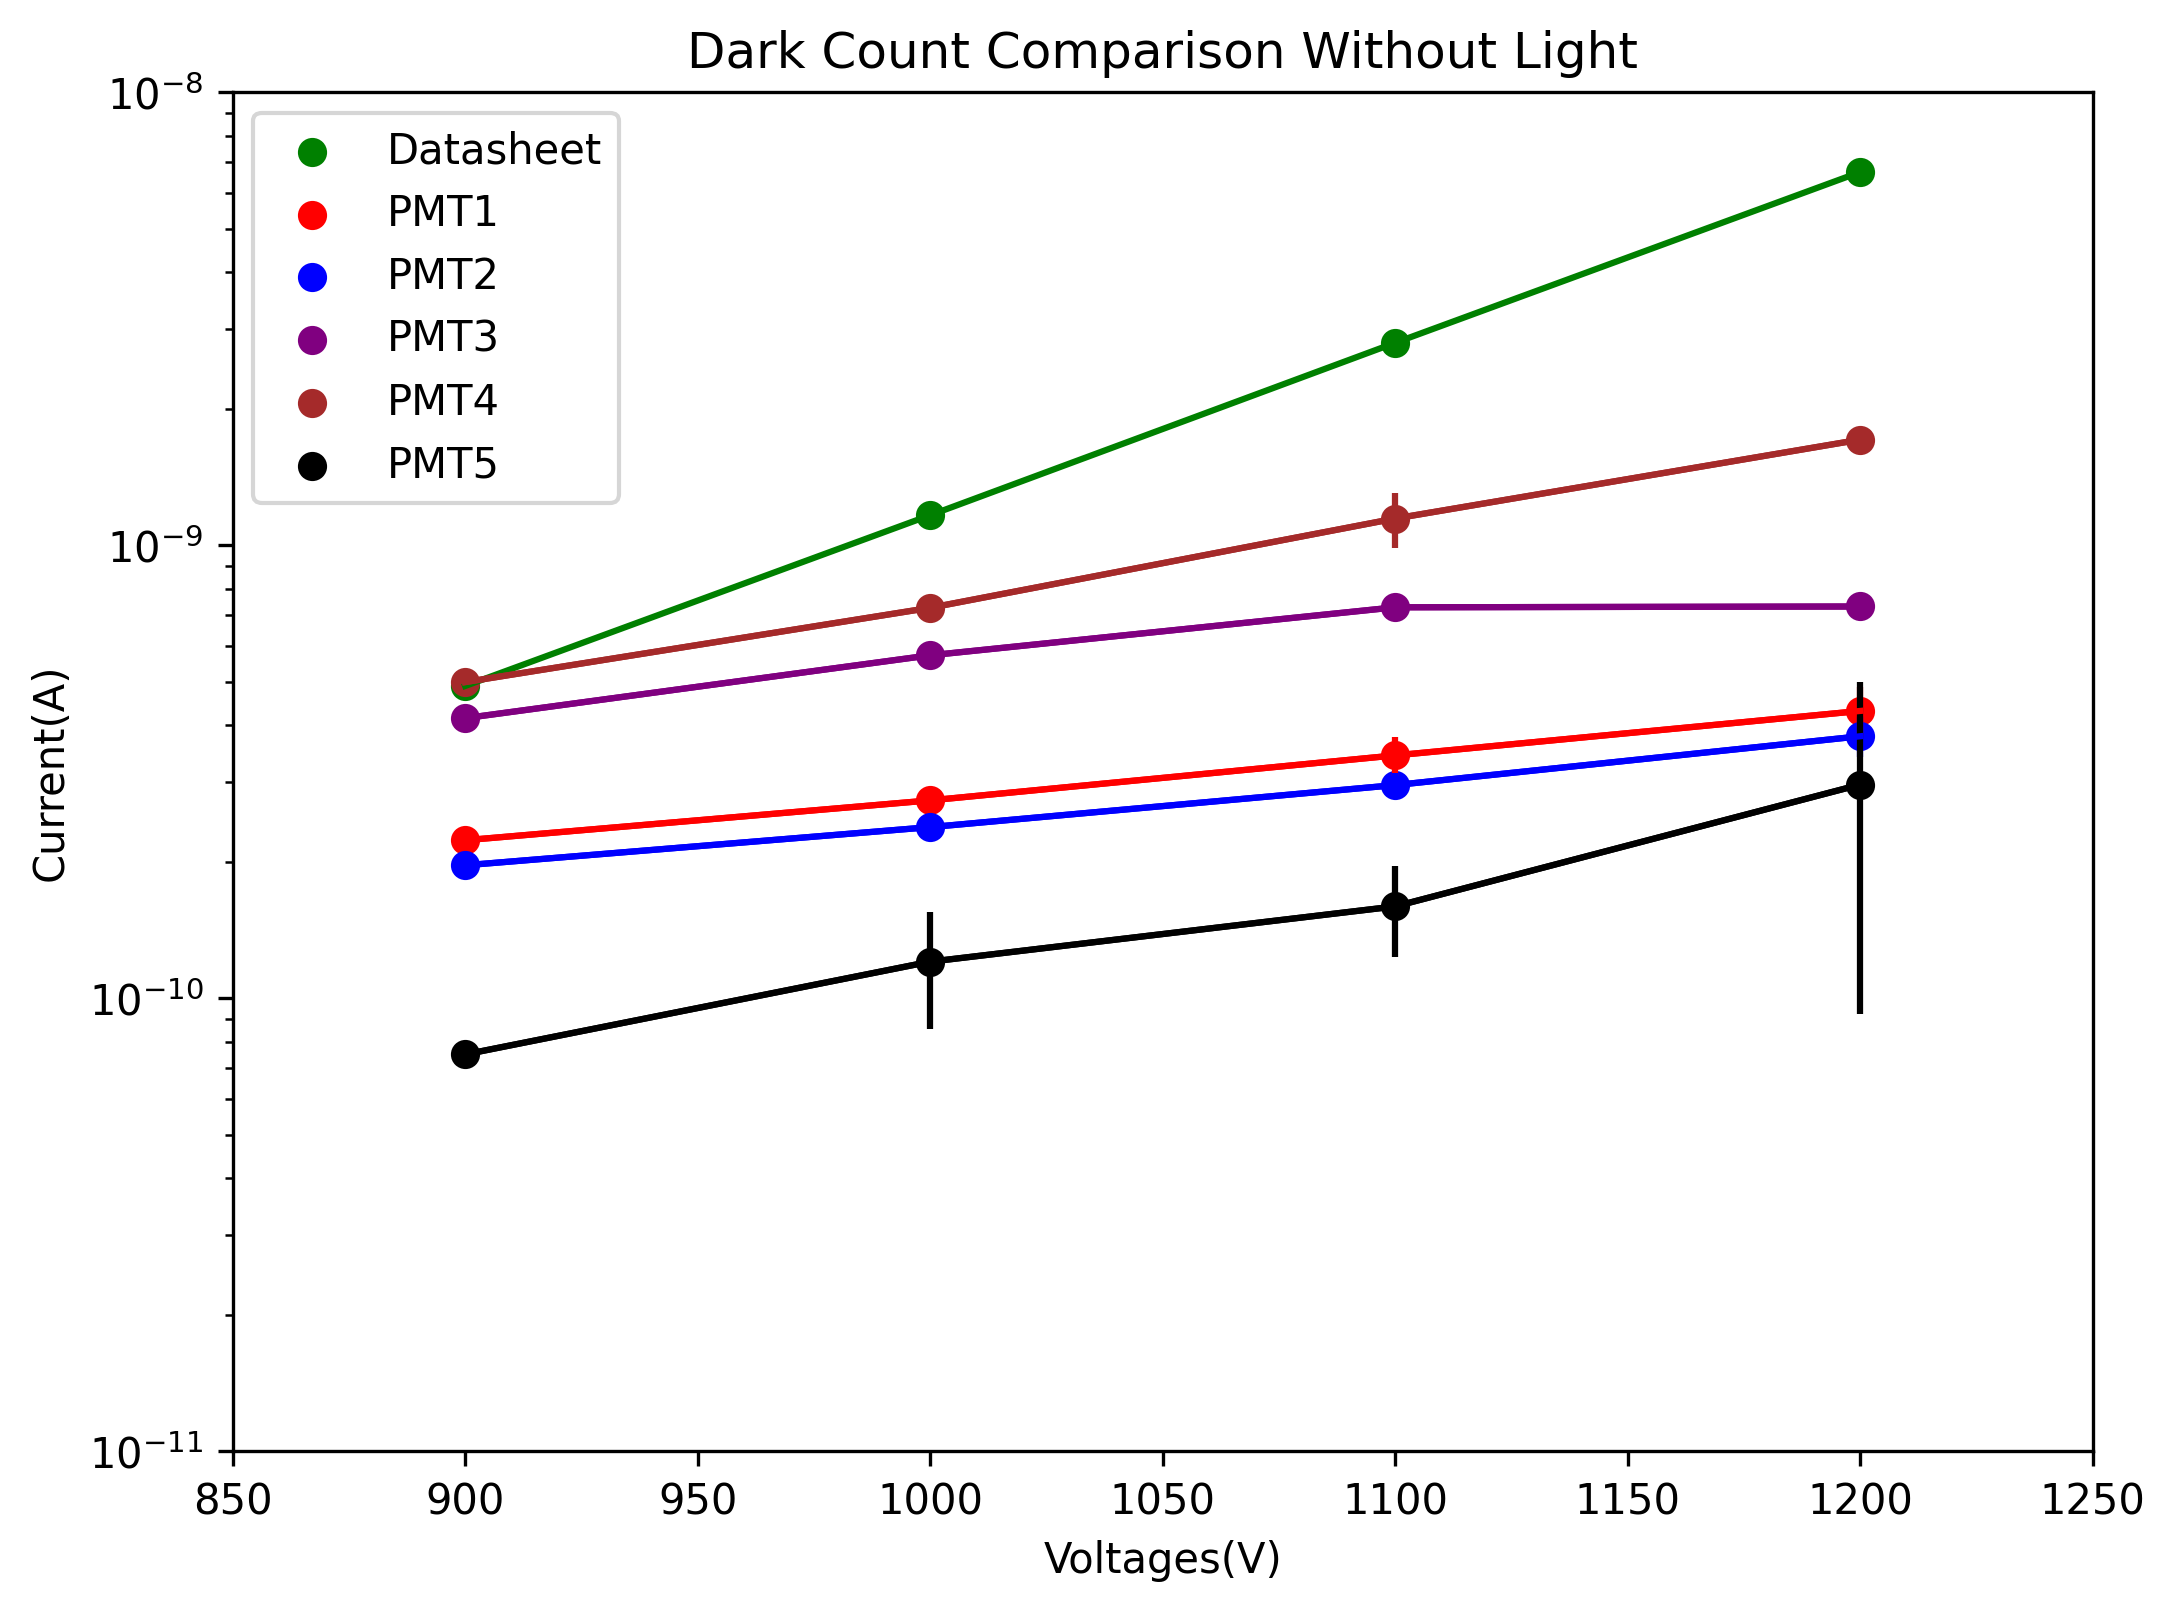

In [5]:

## Dark Count Comparison Plots ##
plt.figure(figsize=(8, 6), dpi=300)
plt.title("Dark Count Comparison Without Light")
plt.xlabel("Voltages(V)")
plt.ylabel("Current(A)")
Datasheet=[Voltages,DataSheetDarkCurrent]
PlotWithTrendLines(Datasheet,"Datasheet","green")
PlotWithTrendLines(PMT1_DarkCounts,"PMT1","red")
PlotWithTrendLines(PMT2_DarkCounts,"PMT2","blue")
PlotWithTrendLines(PMT3_DarkCounts,"PMT3","purple")
PlotWithTrendLines(PMT4_DarkCounts,"PMT4","brown")
PlotWithTrendLines(PMT5_DarkCounts,"PMT5","black")


plt.xlim(850,1250)
plt.ylim(1e-11,1e-8)
plt.semilogy()
plt.legend()




In [6]:
#### Dark Counts With Light ###
#### Dark Counts with Laser off ####
PMT3_DarkCountsWithLight=GetValues("PMT3/Dark/bgnd_withlighton",Voltages,"current_time0.txt",SubFolders=Intensities)
PMT4_DarkCountsWithLight=GetValues("PMT4/Dark/bgnd_withlighton",Voltages,"current_time0.txt",SubFolders=Intensities)
PMT5_DarkCountsWithLight=GetValues("PMT5/Dark/bgnd_withlighton",Voltages,"current_time0.txt",SubFolders=Intensities)


In [7]:
print(PMT3_DarkCountsWithLight)

{900: array([[4.06139580e-10, 5.42996297e-12],
       [4.52267150e-10, 1.11296431e-11],
       [1.00100550e-09, 3.40672246e-11]]), 1000: array([[5.09738420e-10, 1.37855522e-11],
       [6.37778000e-10, 2.55433541e-11],
       [1.97241970e-09, 8.83893151e-11]]), 1100: array([[7.27544180e-10, 4.42341059e-11],
       [1.00688875e-09, 5.99272831e-11],
       [3.84494845e-09, 1.97881327e-10]]), 1200: array([[7.61305260e-10, 5.71395200e-11],
       [1.30115755e-09, 1.17753963e-10],
       [7.36883850e-09, 5.40730448e-10]])}


[[4.52267150e-10 6.37778000e-10 1.00688875e-09 1.30115755e-09]
 [1.11296431e-11 2.55433541e-11 5.99272831e-11 1.17753963e-10]]
[[5.21926333e-10 8.46257557e-10 1.40500887e-09 2.34828773e-09]
 [9.76453236e-12 2.36457626e-11 7.93070863e-11 1.31067552e-10]]
[[1.63106213e-10 3.24174190e-10 7.09952187e-10 1.32703903e-09]
 [1.03284352e-11 4.32240647e-11 9.83325462e-11 1.89949178e-10]]


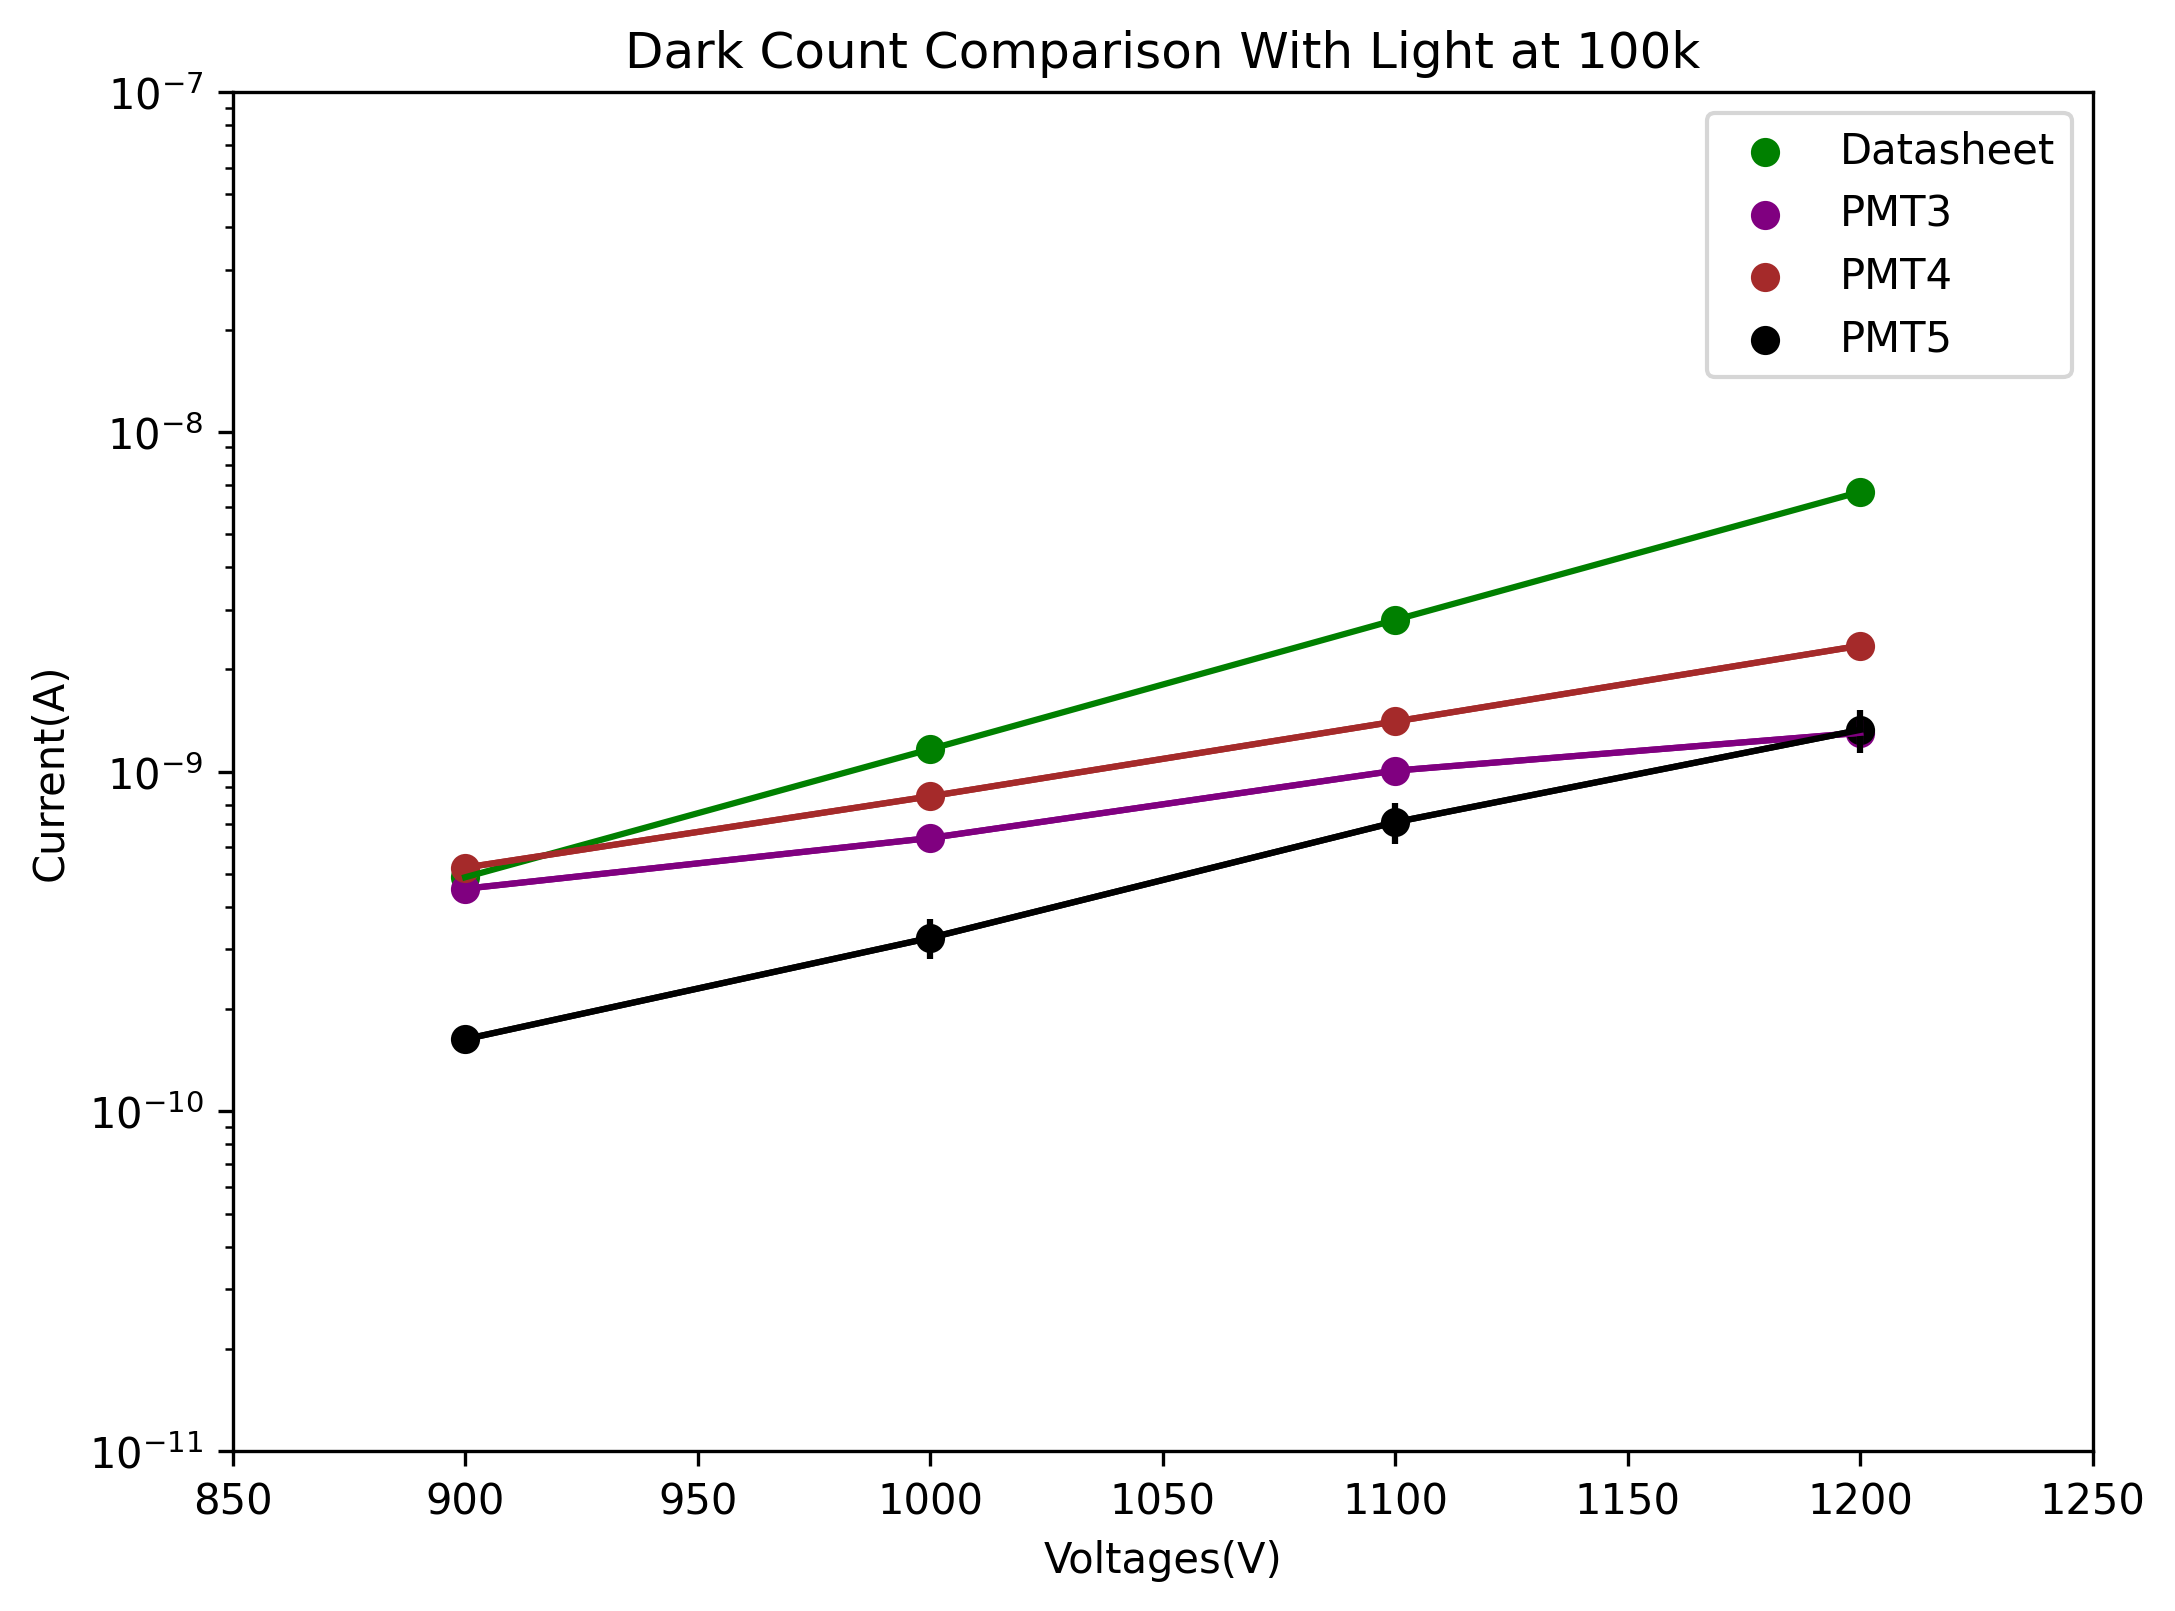

In [8]:

## Dark Count Comparison Plots ##
choice=1
plt.figure(figsize=(8, 6), dpi=300)
plt.title(f"Dark Count Comparison With Light at {Intensities[choice]}")
plt.xlabel("Voltages(V)")
plt.ylabel("Current(A)")

Datasheet=[Voltages,DataSheetDarkCurrent]
PlotWithTrendLines(Datasheet,"Datasheet","green")
PlotWithTrendLines(PMT3_DarkCountsWithLight,"PMT3","purple",choice)
PlotWithTrendLines(PMT4_DarkCountsWithLight,"PMT4","brown",choice)
PlotWithTrendLines(PMT5_DarkCountsWithLight,"PMT5","black",choice)


plt.xlim(850,1250)
plt.ylim(1e-11,1e-7)
plt.semilogy()
plt.legend()


In [9]:
### Testing for Gain
PMT1_Light=GetValues("PMT1/Light",Voltages,"current_time0.txt",SubFolders=Intensities)
PMT2_Light=GetValues("PMT2/Light",Voltages,"current_time0.txt",SubFolders=Intensities)
PMT3_Light=GetValues("PMT3/Light",Voltages,"current_time0.txt",SubFolders=Intensities)
PMT4_Light=GetValues("PMT4/Light",Voltages,"current_time0.txt",SubFolders=Intensities)
PMT5_Light=GetValues("PMT5/Light",Voltages,"current_time0.txt",SubFolders=Intensities)

Plotting Current vs Voltage....


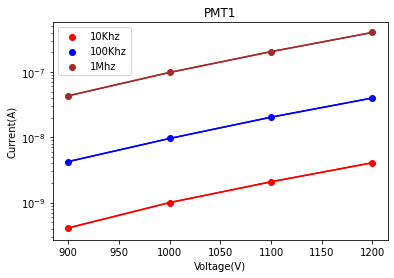

Plotting Gains for  PMT1...
------Average Gain------
[ 262524.01267582  611031.33614648 1279920.96754474 2514478.09755722]
------Gain Error------
[ 5859.27577752 19403.17207908 29554.90165017 90242.58242789]


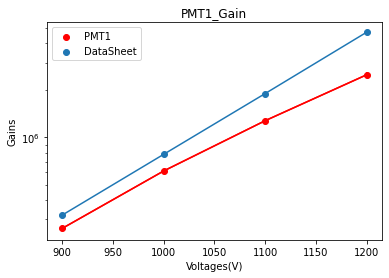

In [10]:

#### Plotting For Gains

gain_PMT1=PlotLightCurrents(PMT1_Light,"PMT1",DataSheetGain,PMT1_DarkCounts)

Plotting Current vs Voltage....


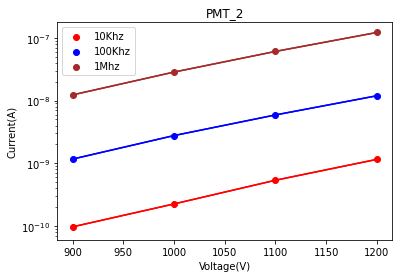

Plotting Gains for  PMT_2...
------Average Gain------
[ 70134.57452767 163749.98970454 361297.04191011 743046.00532251]
------Gain Error------
[ 2278.69309949  6136.5068825  11947.88184486 25083.20801937]


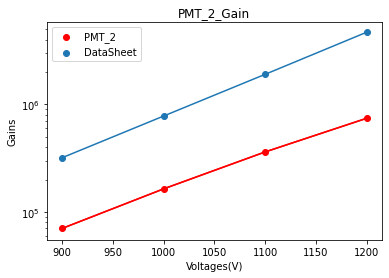

In [11]:

#### Plotting For Gains

gain_PMT2=PlotLightCurrents(PMT2_Light,"PMT_2",DataSheetGain,PMT2_DarkCounts)

Plotting Current vs Voltage....


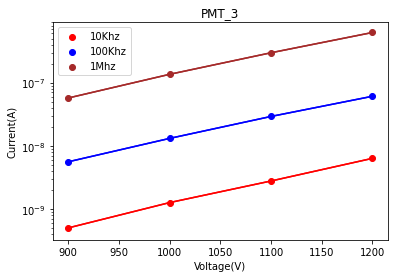

Plotting Gains for  PMT_3...
------Average Gain------
[ 340439.85943612  819684.14309197 1807432.41811278 3887010.81943404]
------Gain Error------
[ 7785.86723632 22240.88877692 33681.52907024 93309.84766086]


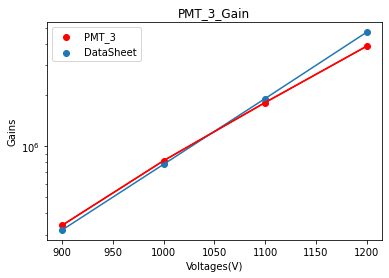

In [12]:
gain_PMT3=PlotLightCurrents(PMT3_Light,"PMT_3",DataSheetGain,PMT3_DarkCounts)

Plotting Current vs Voltage....


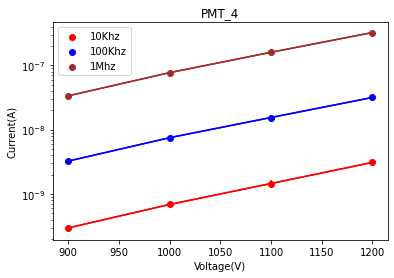

Plotting Gains for  PMT_4...
------Average Gain------
[ 199727.54171175  460659.09560965  958854.57344985 1980861.049244  ]
------Gain Error------
[ 4423.8215321   8984.24681282 42655.15337273 65748.43055471]


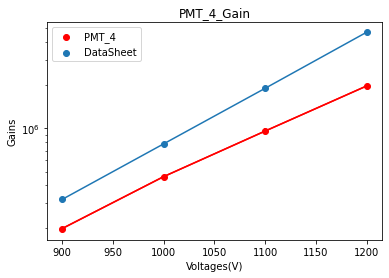

In [13]:

gain_PMT4=PlotLightCurrents(PMT4_Light,"PMT_4",DataSheetGain,PMT4_DarkCounts)

Plotting Current vs Voltage....


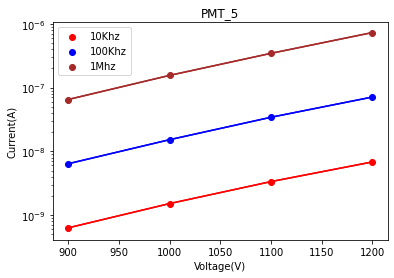

Plotting Gains for  PMT_5...
------Average Gain------
[ 399096.12091622  955488.1075482  2128534.41578582 4422858.79767651]
------Gain Error------
[  9550.60844777  24859.47171896  65195.22779424 148000.36105364]


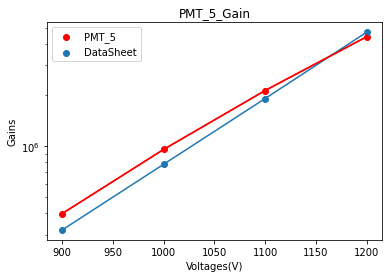

In [14]:

#### For PMT With Teflon ######
gain_PMT5=PlotLightCurrents(PMT5_Light,"PMT_5",DataSheetGain,PMT5_DarkCounts)

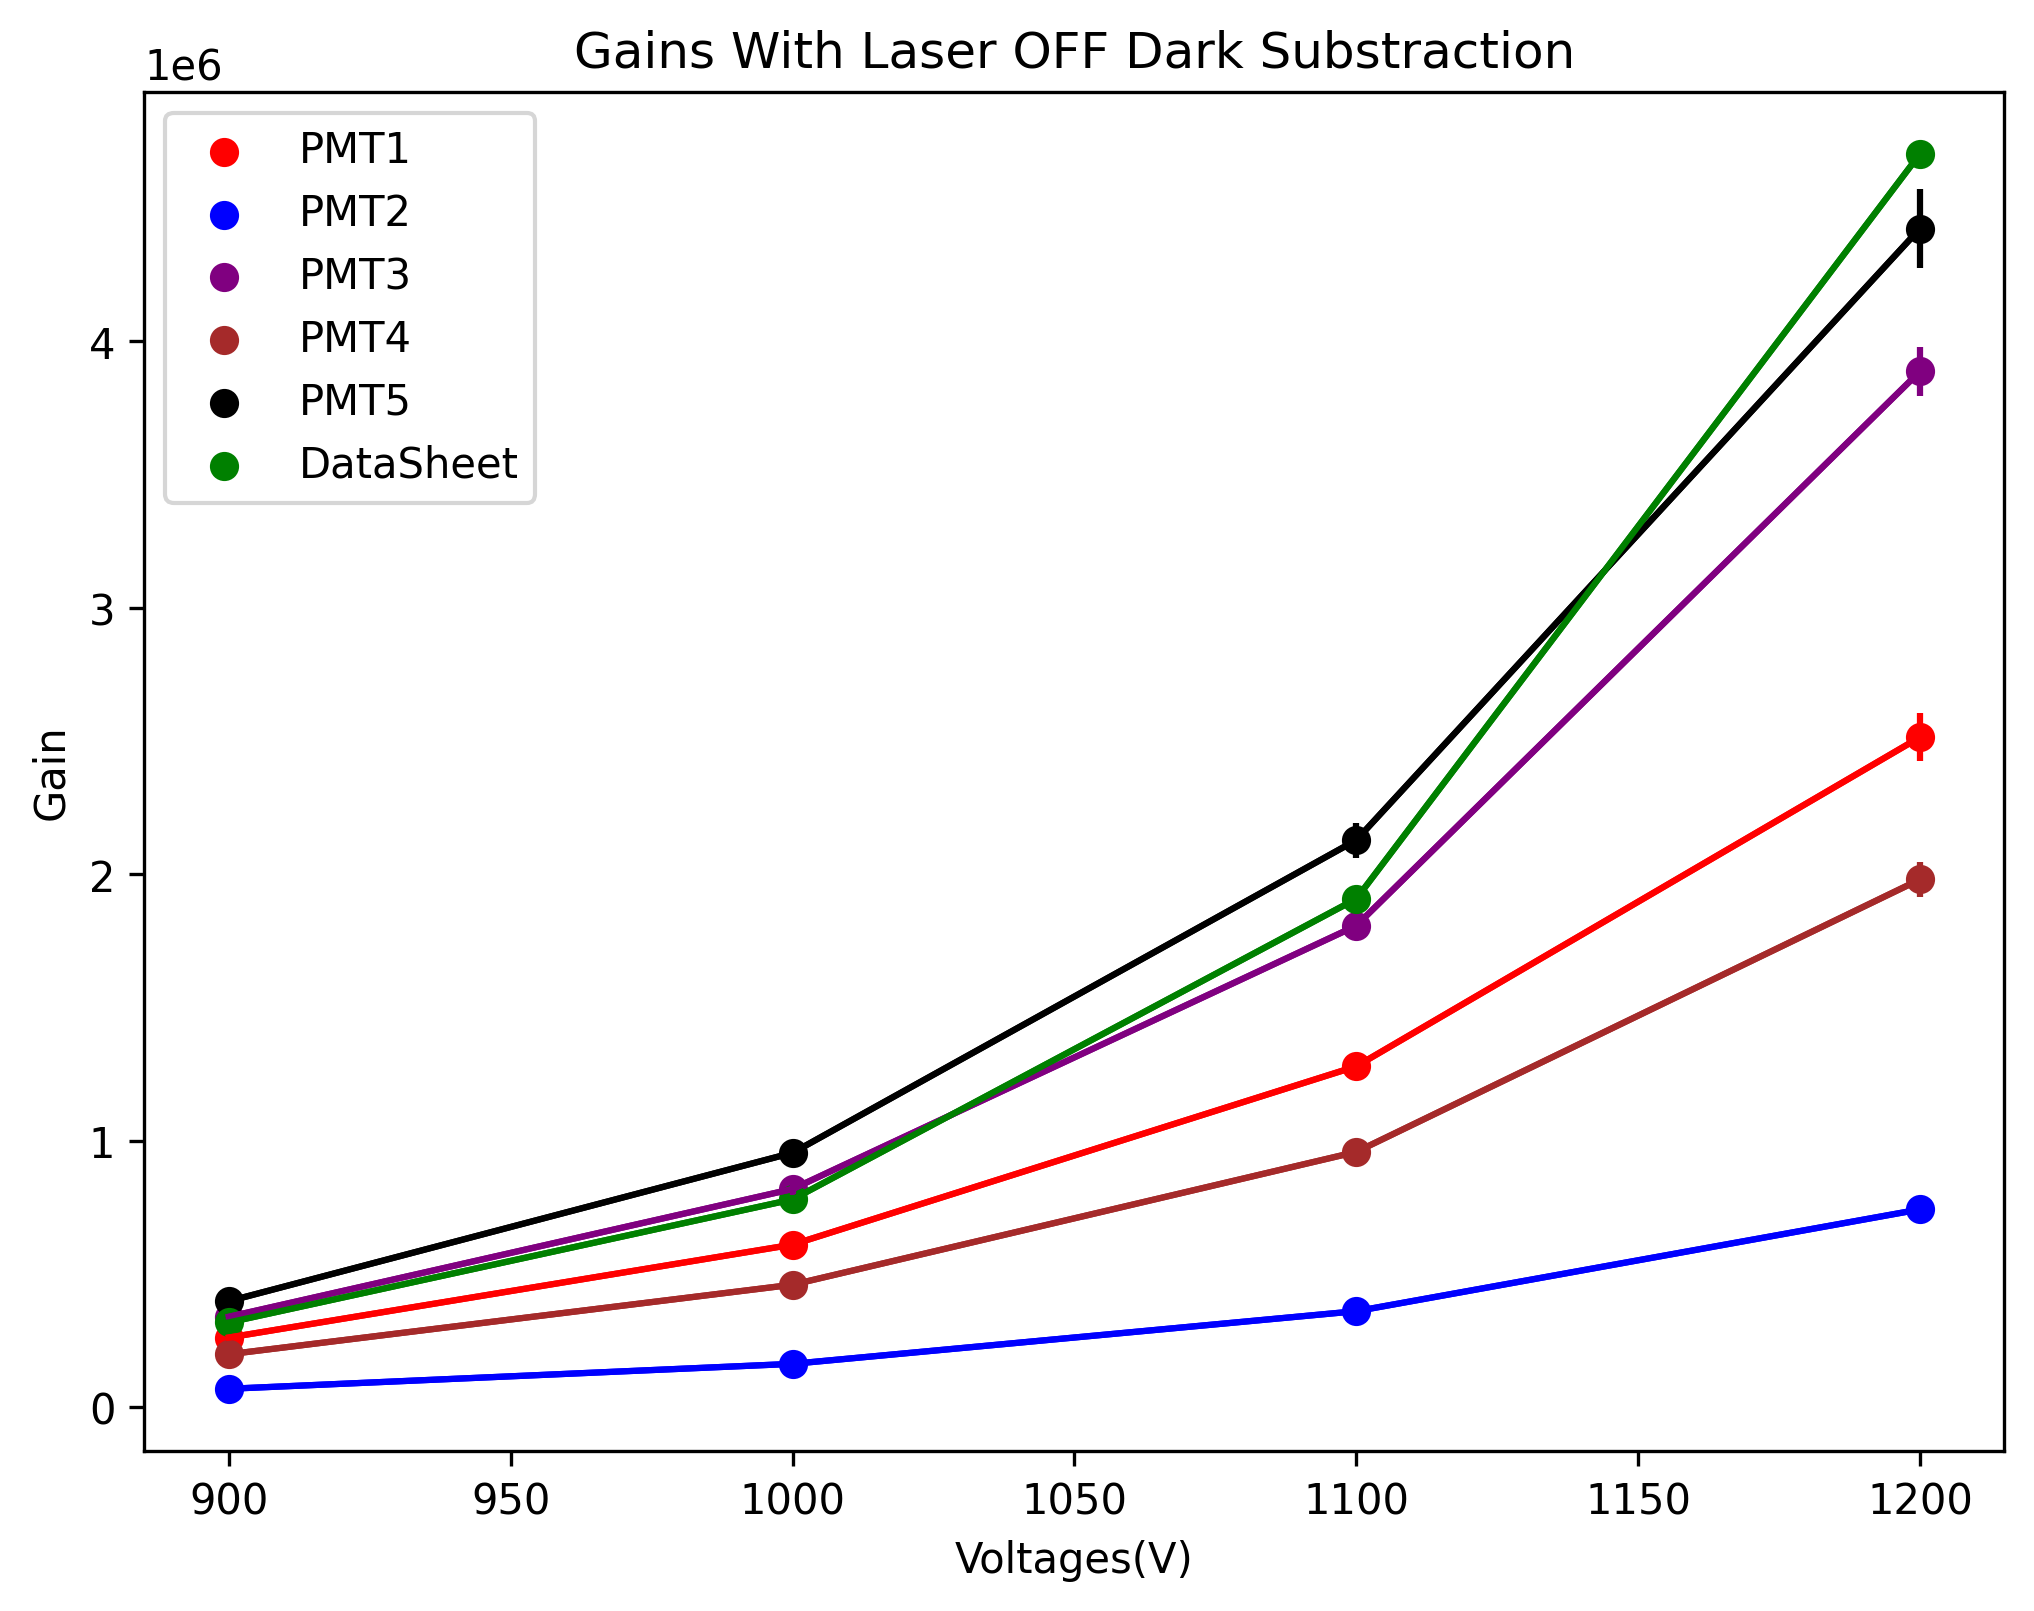

In [25]:
## Light Comparison Plots ##
plt.figure(figsize=(8, 6), dpi=300)
plt.title("Gains With Laser OFF Dark Substraction")
plt.xlabel("Voltages(V)")
plt.ylabel("Gain")
gains=[gain_PMT1[0],gain_PMT2[0],gain_PMT3[0],gain_PMT4[0],gain_PMT5[0],DataSheetGain]
errors=[gain_PMT1[1],gain_PMT2[1],gain_PMT3[1],gain_PMT4[1],gain_PMT5[1],0]
lbls=["PMT1","PMT2","PMT3","PMT4","PMT5","DataSheet"]
clrs=["red","blue","purple","brown","black","green"]
voltages=[Voltages,Voltages,Voltages,Voltages,Voltages,Voltages]


PlotMultipleData(voltages,gains,errors,lbls,clrs)

plt.legend()

Plotting Current vs Voltage....


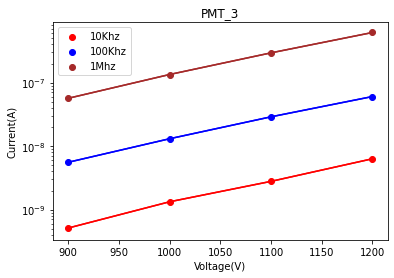

Plotting Gains for  PMT_3...
------Average Gain------
[ 340302.23781731  828194.30565959 1795503.5497295  3855298.78277154]
------Gain Error------
[ 7469.99481552 22360.96323979 34466.50902029 93695.99071495]


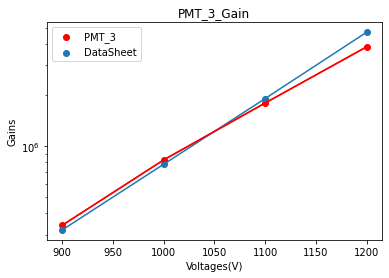

Plotting Current vs Voltage....


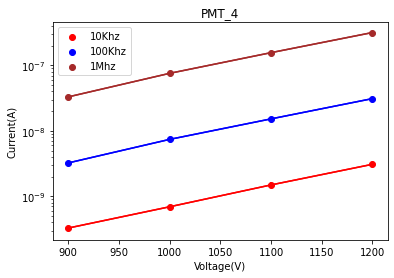

Plotting Gains for  PMT_4...
------Average Gain------
[ 203919.62276321  455290.22728534  953148.04473575 1949841.        ]
------Gain Error------
[ 4431.10563548  8932.15042432 29083.69966361 65124.39072092]


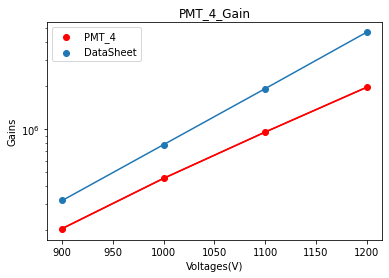

Plotting Current vs Voltage....


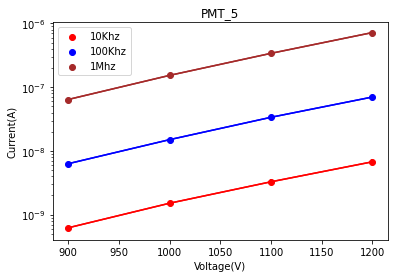

Plotting Gains for  PMT_5...
------Average Gain------
[ 393496.39625468  946023.68227216 2090965.77632127 4363900.65501457]
------Gain Error------
[  9604.90773088  24055.51194282  65601.41328725 143190.30152169]


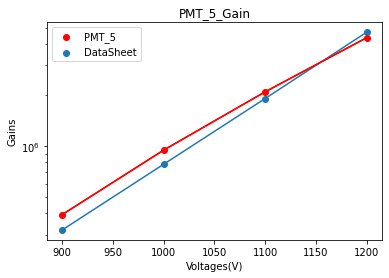

In [21]:
gain_PMT3_WithLight=PlotLightCurrents(PMT3_Light,"PMT_3",DataSheetGain,PMT3_DarkCountsWithLight)

gain_PMT4_WithLight=PlotLightCurrents(PMT4_Light,"PMT_4",DataSheetGain,PMT4_DarkCountsWithLight)
gain_PMT5_WithLight=PlotLightCurrents(PMT5_Light,"PMT_5",DataSheetGain,PMT5_DarkCountsWithLight)



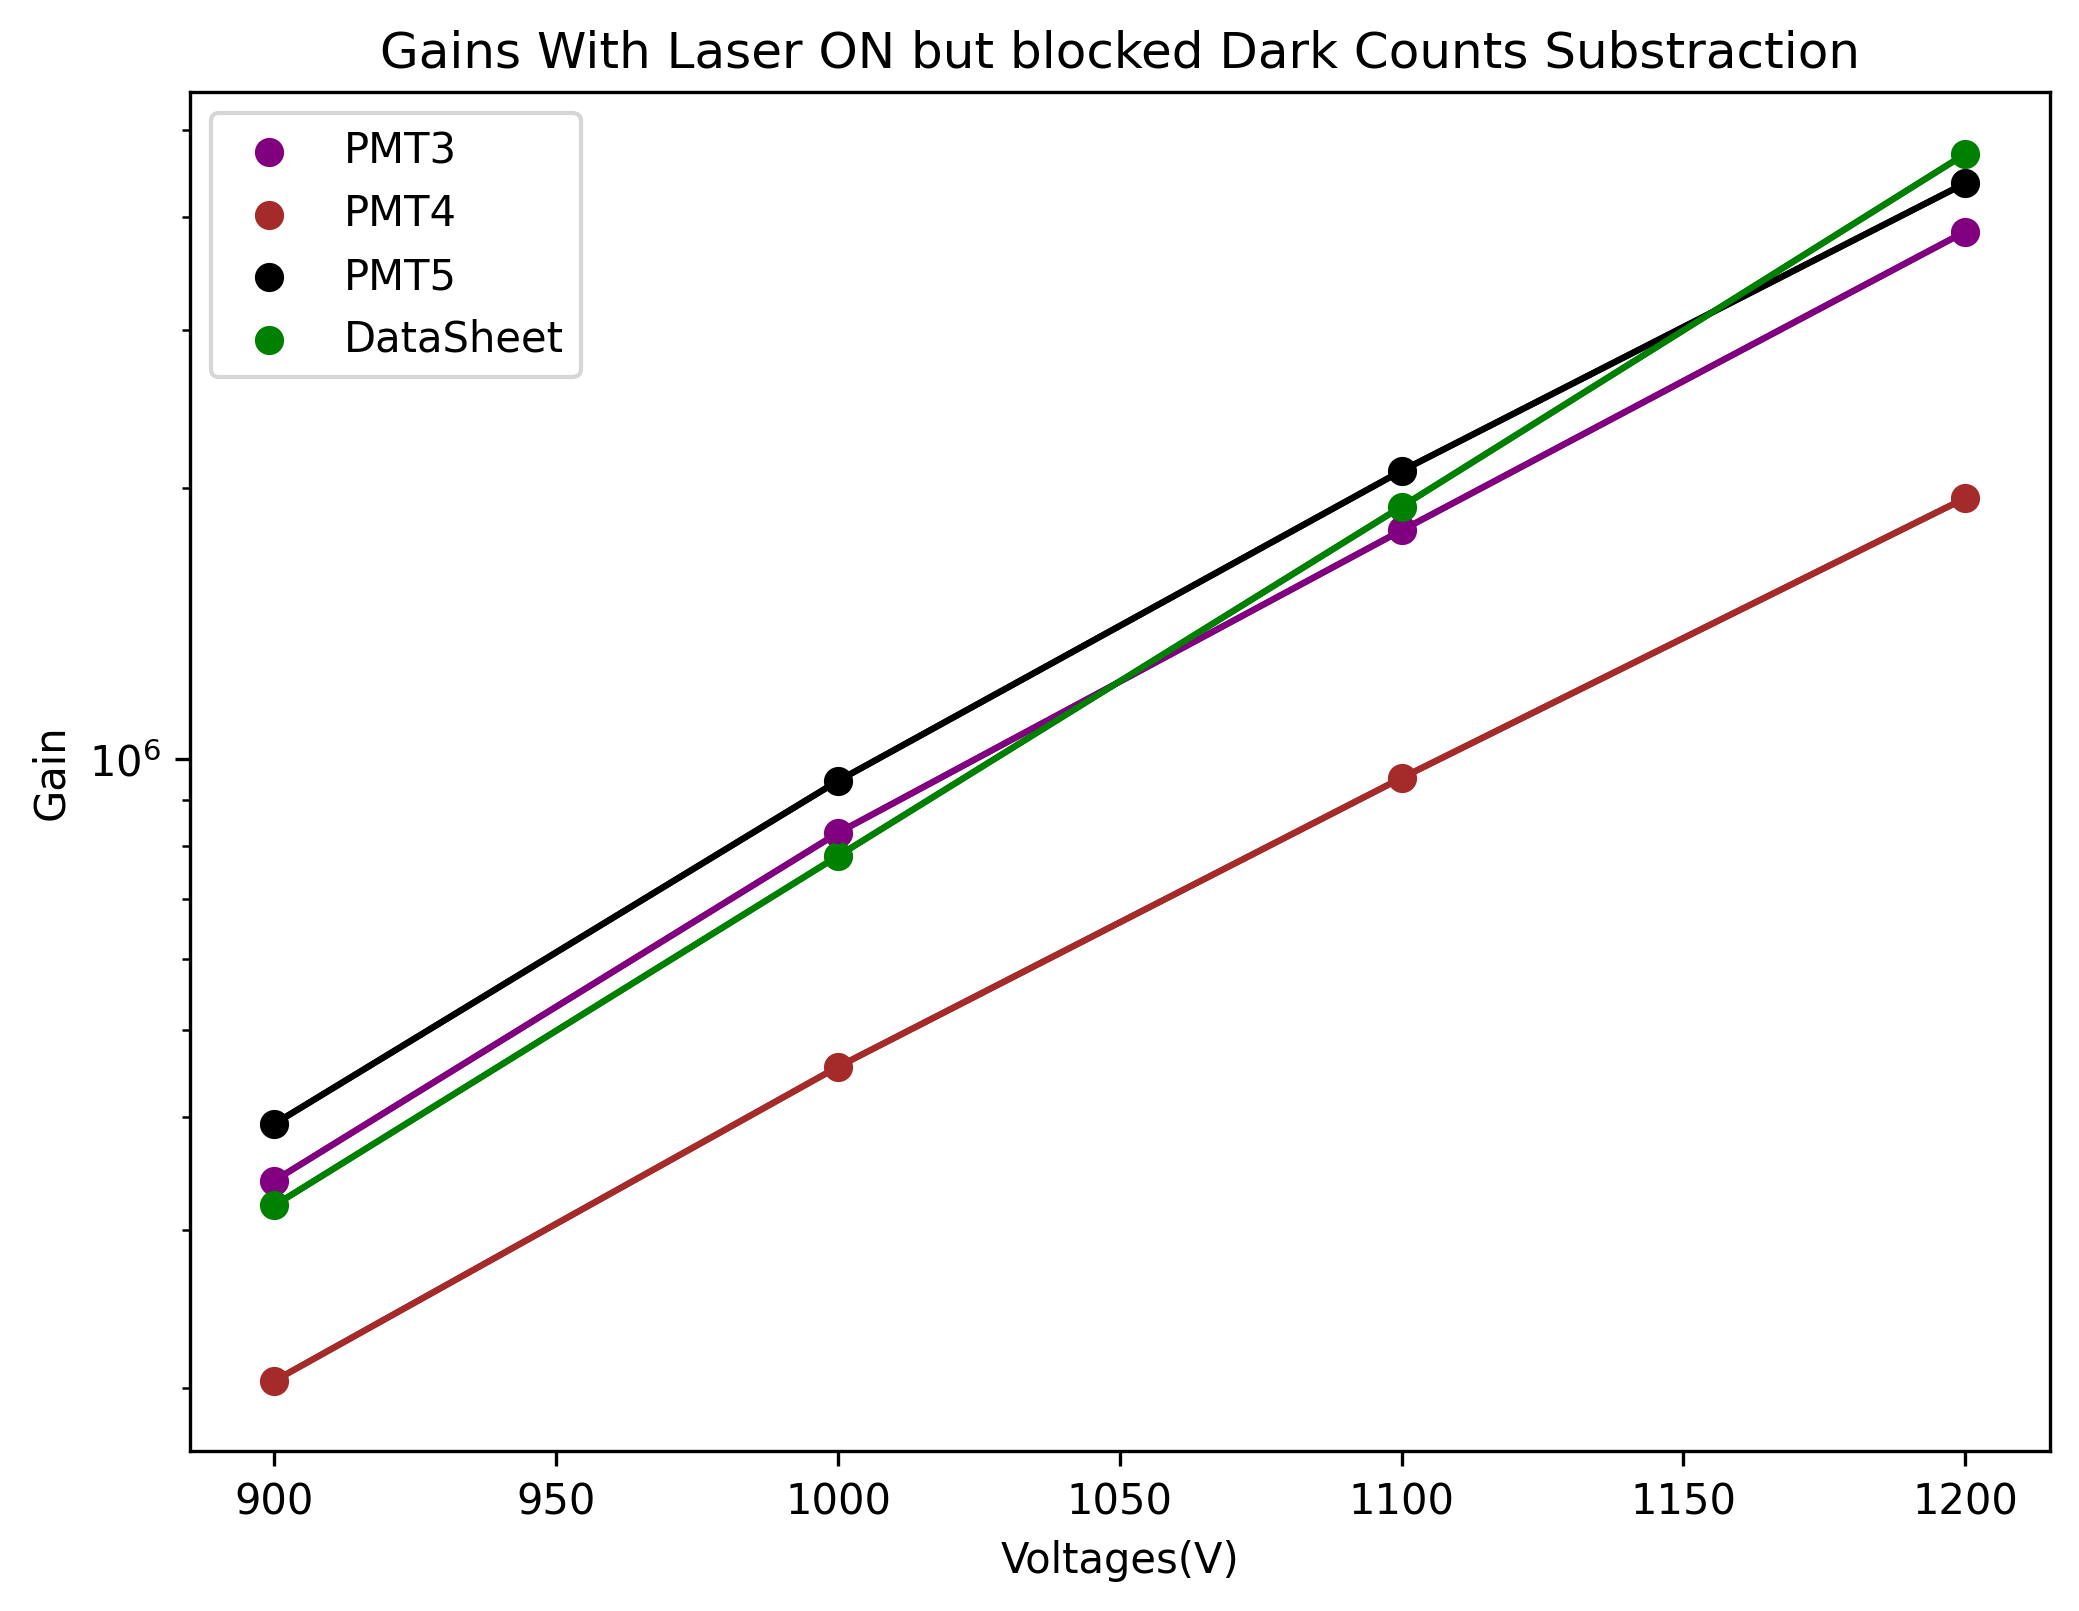

In [23]:
## Dark Count Comparison Plots ##
plt.figure(figsize=(8, 6), dpi=300)
plt.title("Gains With Laser ON but blocked Dark Counts Substraction")
plt.xlabel("Voltages(V)")
plt.ylabel("Gain")
gains=[gain_PMT3_WithLight[0],gain_PMT4_WithLight[0],gain_PMT5_WithLight[0],DataSheetGain]
errors=[gain_PMT3_WithLight[1],gain_PMT4_WithLight[1],gain_PMT5_WithLight[1],0]
lbls=["PMT3","PMT4","PMT5","DataSheet"]
clrs=["purple","brown","black","green"]
voltages=[Voltages,Voltages,Voltages,Voltages]


PlotMultipleData(voltages,gains,errors,lbls,clrs)

plt.semilogy()
plt.legend()